# Run Neural Network On Breast Cancer Data after Dimension Reduction

## Import Packages

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
from time import strftime
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.cluster  import KMeans
from sklearn.mixture import GaussianMixture
import numpy as np
from numpy import array
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

## Load Breast Cancer Dataset

In [2]:
bc_dataset = pd.read_csv("../data/breast_cancer_dataset.csv")
bc_dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# Map diagnosis column to integer value: 0, 1, drop the id, and diagnosis columns
data = bc_dataset.copy()
data["diagnosis"] = bc_dataset["diagnosis"].map({"M": 1, "B":0})
X = data.drop(['id', 'diagnosis'], axis=1)
y = data["diagnosis"]

In [4]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)

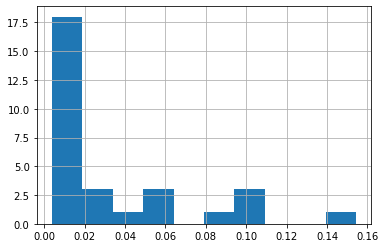

In [5]:
# Using RandomForestClassifier
bc_sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
bc_sel.fit(X_train, y_train)
bc_sel.get_support()
bc_selected_feat= X_train.columns[(bc_sel.get_support())]
pd.Series(bc_sel.estimator_.feature_importances_.ravel()).hist()
X_selected = X[bc_selected_feat]

In [6]:
# Split feature selected data into train and test set
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_selected, y, test_size=0.2, random_state=3, stratify=y)

### Run Neural Network with dimensionality reduction using decision tree

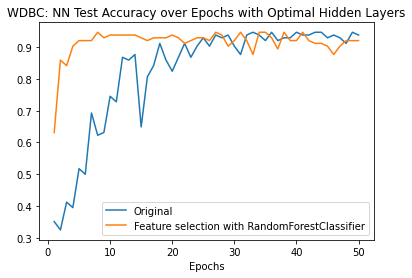

In [7]:
warnings.simplefilter('ignore', category=DeprecationWarning)

plt.figure()
n_epochs = 51
epoch_graph = range(1, 51, 1)
    
# Original
train_features = X_train.values
train_labels = y_train.values
test_features = X_test.values
test_labels = y_test.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
    
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_dt.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset (No Dimensionality Reduction)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

    
plt.plot(epoch_graph, scores_test)


train_features = X_train_s.values
train_labels = y_train_s.values
test_features = X_test_s.values
test_labels = y_test_s.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
    
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_dt.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - DT \n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

        
plt.plot(epoch_graph, scores_test)

plt.legend(["Original", "Feature selection with RandomForestClassifier"])
plt.title("WDBC: NN Test Accuracy over Epochs with Optimal Hidden Layers")
plt.xlabel("Epochs")
plt.show()

### Run Nueral Network with dimensionality reduction using PCA

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

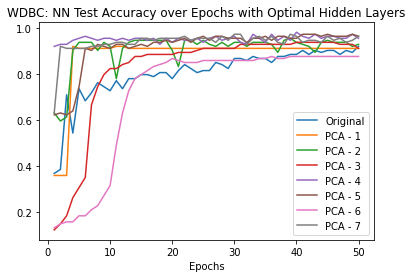

In [8]:
plt.figure()
n_epochs = 51
epoch_graph = range(1, 51, 1)
    
# Original
train_features = X_train.values
train_labels = y_train.values
test_features = X_test.values
test_labels = y_test.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
    
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_pca.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset (No Dimensionality Reduction)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

    
plt.plot(epoch_graph, scores_test)

for n in range(1, 8, 1):    
    pca = PCA(n_components = n)
    pca.fit(X_train)
    train_features = pca.transform(X_train)
    test_features = pca.transform(X_test)
    num_layers = range(10)
    accuracy_train_layer = []
    accuracy_test_layer = []
    start_time = datetime.now()

    for layer in num_layers:
        classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
        classifier.fit(train_features, train_labels)
        accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
        accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

    optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
    classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

    n_train_samples = train_features.shape[0]
        
    n_batch = 32
    n_classes = np.unique(train_labels)

    scores_train = []
    scores_test = []
    epoch = 1
    while epoch < n_epochs:
        random_perm = np.random.permutation(train_features.shape[0])
        mini_batch_index = 0
        while True:
            indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
            classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
            mini_batch_index += n_batch

            if mini_batch_index >= n_train_samples:
                break

        scores_train.append(classifier.score(train_features, train_labels.ravel()))
        scores_test.append(classifier.score(test_features, test_labels.ravel()))

        epoch += 1

    end_time = datetime.now()
    total_time_taken = str(end_time - start_time)
    train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
    cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
    test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

    with open("../results/ann_breast_cancer_pca.txt", 'a') as file:
        file.write("ANN with Breast Cancer Dataset - PCA (" + str(n) + " principal components)\n\n")
        file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
        file.write("Training Accuracy: " + str(train_accuracy) + "\n")
        file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
        file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
        file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

        
    plt.plot(epoch_graph, scores_test)

plt.legend(["Original", "PCA - 1", "PCA - 2", "PCA - 3", "PCA - 4", "PCA - 5", "PCA - 6", "PCA - 7"])
plt.title("WDBC: NN Test Accuracy over Epochs with Optimal Hidden Layers")
plt.xlabel("Epochs")
plt.show()

### Run Neural Network with dimensionality reduction using ICA

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

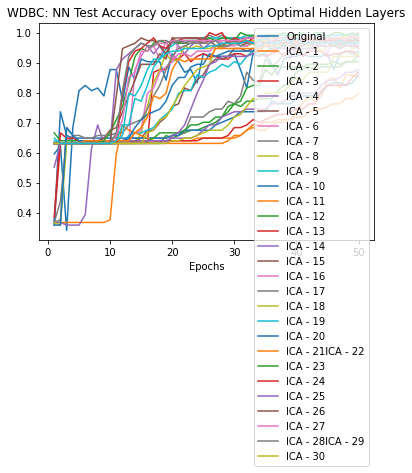

In [9]:
plt.figure()
n_epochs = 51
epoch_graph = range(1, 51, 1)
    
# Original
train_features = X_train.values
train_labels = y_train.values
test_features = X_test.values
test_labels = y_test.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
    
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_pca.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset (No Dimensionality Reduction)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

    
plt.plot(epoch_graph, scores_test)

for n in range(1, 30, 1): 
    ica = FastICA(n_components = n)
    ica.fit(X_train)
    train_features = ica.transform(X_train)
    test_features = ica.transform(X_test)
    num_layers = range(10)
    accuracy_train_layer = []
    accuracy_test_layer = []
    start_time = datetime.now()

    for layer in num_layers:
        classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
        classifier.fit(train_features, train_labels)
        accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
        accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

    optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
    classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

    n_train_samples = train_features.shape[0]
        
    n_batch = 32
    n_classes = np.unique(train_labels)

    scores_train = []
    scores_test = []
    epoch = 1
    while epoch < n_epochs:
        random_perm = np.random.permutation(train_features.shape[0])
        mini_batch_index = 0
        while True:
            indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
            classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
            mini_batch_index += n_batch

            if mini_batch_index >= n_train_samples:
                break

        scores_train.append(classifier.score(train_features, train_labels.ravel()))
        scores_test.append(classifier.score(test_features, test_labels.ravel()))

        epoch += 1

    end_time = datetime.now()
    total_time_taken = str(end_time - start_time)
    train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
    cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
    test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

    with open("../results/ann_breast_cancer_ica.txt", 'a') as file:
        file.write("ANN with Breast Cancer Dataset - ICA (" + str(n) + " independent components)\n\n")
        file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
        file.write("Training Accuracy: " + str(train_accuracy) + "\n")
        file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
        file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
        file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")
        
    plt.plot(epoch_graph, scores_test)

plt.legend(["Original", "ICA - 1", "ICA - 2", "ICA - 3", "ICA - 4", "ICA - 5", "ICA - 6", "ICA - 7",
                "ICA - 8", "ICA - 9", "ICA - 10", "ICA - 11", "ICA - 12", "ICA - 13", "ICA - 14",
                "ICA - 15", "ICA - 16", "ICA - 17", "ICA - 18", "ICA - 19", "ICA - 20", "ICA - 21"
                "ICA - 22", "ICA - 23", "ICA - 24", "ICA - 25", "ICA - 26", "ICA - 27", "ICA - 28"
                "ICA - 29", "ICA - 30"])
plt.title("WDBC: NN Test Accuracy over Epochs with Optimal Hidden Layers")
plt.xlabel("Epochs")
plt.show()


### Run Neural Network with dimensionality reduction using random projection

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

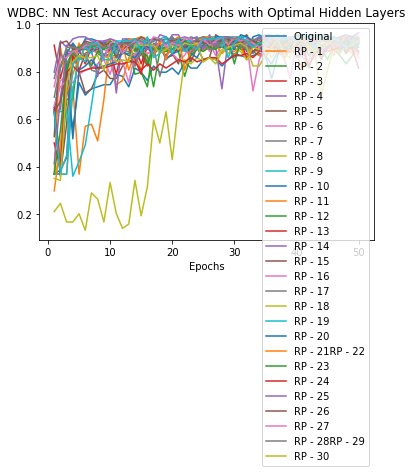

In [10]:
plt.figure()
n_epochs = 51
epoch_graph = range(1, 51, 1)
    
# Original
train_features = X_train.values
train_labels = y_train.values
test_features = X_test.values
test_labels = y_test.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
    
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_rp.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset (No Dimensionality Reduction)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

    
plt.plot(epoch_graph, scores_test)

for n in range(1, 30, 1): 
    rp = GaussianRandomProjection(n_components = n)
    rp.fit(X_train)
    train_features = rp.transform(X_train)
    test_features = rp.transform(X_test)
    num_layers = range(10)
    accuracy_train_layer = []
    accuracy_test_layer = []
    start_time = datetime.now()

    for layer in num_layers:
        classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
        classifier.fit(train_features, train_labels)
        accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
        accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

    optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
    classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

    n_train_samples = train_features.shape[0]
        
    n_batch = 32
    n_classes = np.unique(train_labels)

    scores_train = []
    scores_test = []
    epoch = 1
    while epoch < n_epochs:
        random_perm = np.random.permutation(train_features.shape[0])
        mini_batch_index = 0
        while True:
            indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
            classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
            mini_batch_index += n_batch

            if mini_batch_index >= n_train_samples:
                break

        scores_train.append(classifier.score(train_features, train_labels.ravel()))
        scores_test.append(classifier.score(test_features, test_labels.ravel()))

        epoch += 1

    end_time = datetime.now()
    total_time_taken = str(end_time - start_time)
    train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
    cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
    test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

    with open("../results/ann_breast_cancer_rp.txt", 'a') as file:
        file.write("ANN with Breast Cancer Dataset - RP (" + str(n) + " random projections)\n\n")
        file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
        file.write("Training Accuracy: " + str(train_accuracy) + "\n")
        file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
        file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
        file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

        
    plt.plot(epoch_graph, scores_test)

plt.legend(["Original", "RP - 1", "RP - 2", "RP - 3", "RP - 4", "RP - 5", "RP - 6", "RP - 7",
                "RP - 8", "RP - 9", "RP - 10", "RP - 11", "RP - 12", "RP - 13", "RP - 14",
                "RP - 15", "RP - 16", "RP - 17", "RP - 18", "RP - 19", "RP - 20", "RP - 21"
                "RP - 22", "RP - 23", "RP - 24", "RP - 25", "RP - 26", "RP - 27", "RP - 28"
                "RP - 29", "RP - 30"])
plt.title("WDBC: NN Test Accuracy over Epochs with Optimal Hidden Layers")
plt.xlabel("Epochs")
plt.savefig("nn_breast_cancer_rp.png")
plt.show()

### Dimesionality reduction on Neural Network performance

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

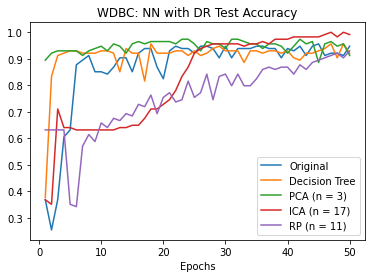

In [11]:
plt.figure()
n_epochs = 51
epoch_graph = range(1, 51, 1)
    
# Original
train_features = X_train.values
train_labels = y_train.values
test_features = X_test.values
test_labels = y_test.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
    
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_summary.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset (No Dimensionality Reduction)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

    
plt.plot(epoch_graph, scores_test)


train_features = X_train_s.values
train_labels = y_train_s.values
test_features = X_test_s.values
test_labels = y_test_s.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
    
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_summary.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - DT \n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

        
plt.plot(epoch_graph, scores_test)

# PCA 
pca = PCA(n_components = 3)
pca.fit(X_train)
train_features = pca.transform(X_train)
test_features = pca.transform(X_test)
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
        
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_summary.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - PCA (" + "3" + " principal components)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

        
plt.plot(epoch_graph, scores_test)

# ICA

ica = FastICA(n_components = 17)
ica.fit(X_train)
train_features = ica.transform(X_train)
test_features = ica.transform(X_test)
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
        
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_summary.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - ICA (" + "17" + " independent components)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")
        
plt.plot(epoch_graph, scores_test)

# Random projection

rp = GaussianRandomProjection(n_components = 11)
rp.fit(X_train)
train_features = rp.transform(X_train)
test_features = rp.transform(X_test)
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]

n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_summary.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - RP (" + "11" + " random projections)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")


plt.plot(epoch_graph, scores_test)

plt.legend(["Original", "Decision Tree", "PCA (n = 3)", "ICA (n = 17)", "RP (n = 11)"])
plt.title("WDBC: NN with DR Test Accuracy")
plt.xlabel("Epochs")
plt.show()

### Dimensionality Reduction and Clustering on Neural Network performance

d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

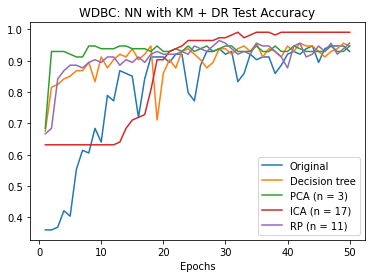

In [12]:
plt.figure()
n_epochs = 51
epoch_graph = range(1, 51, 1)

# Original
train_features = X_train.values
train_labels = y_train.values
test_features = X_test.values
test_labels = y_test.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]

n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_km.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset (No Clustering/DR)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")


plt.plot(epoch_graph, scores_test)

kmeans = KMeans(n_clusters=2).fit(X)
clusters = pd.Series(kmeans.labels_)
X["Cluster"] = clusters.values

# Split data into train and test set
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)

# Original
train_features = X_train_c.values
train_labels = y_train_c.values
test_features = X_test_c.values
test_labels = y_test_c.values

# RandomForestClassifier
bc_sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
bc_sel.fit(X_train, y_train)
bc_sel.get_support()
bc_selected_feat= X_train.columns[(bc_sel.get_support())]
X_selected_c = X[bc_selected_feat]
# Split feature selected data into train and test set
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_selected_c, y, test_size=0.2, random_state=3, stratify=y)

train_features = X_train_sc.values
train_labels = y_train_sc.values
test_features = X_test_sc.values
test_labels = y_test_sc.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
    
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_km.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - DT \n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

        
plt.plot(epoch_graph, scores_test)


# PCA
# Original
train_features = X_train_c.values
train_labels = y_train_c.values
test_features = X_test_c.values
test_labels = y_test_c.values

pca = PCA(n_components = 3)
pca.fit(train_features)
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]

n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_km.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - PCA/KM (" + "3" + " principal components, 2 clusters)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")


plt.plot(epoch_graph, scores_test)


#ICA
# Original
train_features = X_train_c.values
train_labels = y_train_c.values
test_features = X_test_c.values
test_labels = y_test_c.values

ica = FastICA(n_components = 17)
ica.fit(train_features)
train_features = ica.transform(train_features)
test_features = ica.transform(test_features)
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]

n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_km.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - ICA/KM (" + "17" + " independent components, 2 clusters)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")


plt.plot(epoch_graph, scores_test)

# random projection
# Original
train_features = X_train_c.values
train_labels = y_train_c.values
test_features = X_test_c.values
test_labels = y_test_c.values

rp = GaussianRandomProjection(n_components = 11)
rp.fit(train_features)
train_features = rp.transform(train_features)
test_features = rp.transform(test_features)
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]

n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_km.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - RP/KM (" + "11" + " random projections, 2 clusters)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")


plt.plot(epoch_graph, scores_test)


plt.legend(["Original", "Decision tree", "PCA (n = 3)", "ICA (n = 17)", "RP (n = 11)"])
plt.title("WDBC: NN with KM + DR Test Accuracy")
plt.xlabel("Epochs")
plt.show()


d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
d:\python_projects\cs7641_hw3\ve

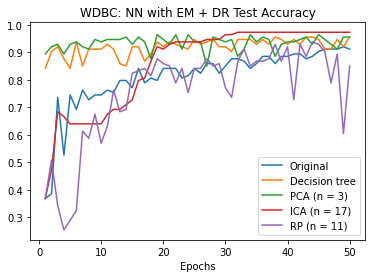

In [13]:
plt.figure()
n_epochs = 51
epoch_graph = range(1, 51, 1)

# Original
train_features = X_train.values
train_labels = y_train.values
test_features = X_test.values
test_labels = y_test.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]

n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_em.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset (No Clustering/DR)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")


plt.plot(epoch_graph, scores_test)

gmm = GaussianMixture(n_components=2).fit(X)
clusters = gmm.predict(X)
X["Cluster"] = clusters

# Split data into train and test set
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)

# Original
train_features = X_train_c.values
train_labels = y_train_c.values
test_features = X_test_c.values
test_labels = y_test_c.values

# RandomForestClassifier
bc_sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
bc_sel.fit(X_train, y_train)
bc_sel.get_support()
bc_selected_feat= X_train.columns[(bc_sel.get_support())]
X_selected_c = X[bc_selected_feat]
# Split feature selected data into train and test set
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_selected_c, y, test_size=0.2, random_state=3, stratify=y)

train_features = X_train_sc.values
train_labels = y_train_sc.values
test_features = X_test_sc.values
test_labels = y_test_sc.values
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
        alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]
    
n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_em.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - DT \n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")

        
plt.plot(epoch_graph, scores_test)


# PCA
# Original
train_features = X_train_c.values
train_labels = y_train_c.values
test_features = X_test_c.values
test_labels = y_test_c.values

pca = PCA(n_components = 3)
pca.fit(train_features)
train_features = pca.transform(train_features)
test_features = pca.transform(test_features)
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]

n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_em.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - PCA/EM (" + "3" + " principal components, 2 clusters)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")


plt.plot(epoch_graph, scores_test)


#ICA
# Original
train_features = X_train_c.values
train_labels = y_train_c.values
test_features = X_test_c.values
test_labels = y_test_c.values

ica = FastICA(n_components = 17)
ica.fit(train_features)
train_features = ica.transform(train_features)
test_features = ica.transform(test_features)
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]

n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_em.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - ICA/EM (" + "17" + " independent components, 2 clusters)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")


plt.plot(epoch_graph, scores_test)

# random projection
# Original
train_features = X_train_c.values
train_labels = y_train_c.values
test_features = X_test_c.values
test_labels = y_test_c.values

rp = GaussianRandomProjection(n_components = 11)
rp.fit(train_features)
train_features = rp.transform(train_features)
test_features = rp.transform(test_features)
num_layers = range(10)
accuracy_train_layer = []
accuracy_test_layer = []
start_time = datetime.now()

for layer in num_layers:
    classifier = MLPClassifier(hidden_layer_sizes=tuple(layer * [16]), max_iter=600)
    classifier.fit(train_features, train_labels)
    accuracy_train_layer.append(accuracy_score(train_labels, classifier.predict(train_features)))
    accuracy_test_layer.append(accuracy_score(test_labels, classifier.predict(test_features)))

optimal_num_layers = accuracy_test_layer.index(max(accuracy_test_layer))
classifier = MLPClassifier(hidden_layer_sizes=(optimal_num_layers * [16]), max_iter=500,
    alpha=1e-4, solver='adam', verbose=0, tol=1e-8, random_state=1)

n_train_samples = train_features.shape[0]

n_batch = 32
n_classes = np.unique(train_labels)

scores_train = []
scores_test = []
epoch = 1
while epoch < n_epochs:
    random_perm = np.random.permutation(train_features.shape[0])
    mini_batch_index = 0
    while True:
        indices = random_perm[mini_batch_index:mini_batch_index + n_batch]
        classifier.partial_fit(train_features[indices], train_labels[indices], classes=n_classes)
        mini_batch_index += n_batch

        if mini_batch_index >= n_train_samples:
            break

    scores_train.append(classifier.score(train_features, train_labels.ravel()))
    scores_test.append(classifier.score(test_features, test_labels.ravel()))

    epoch += 1

end_time = datetime.now()
total_time_taken = str(end_time - start_time)
train_accuracy = accuracy_score(train_labels, classifier.predict(train_features))
cross_validation_accuracy = cross_val_score(classifier, train_features, train_labels, cv=7).mean()
test_accuracy = accuracy_score(test_labels, classifier.predict(test_features))

with open("../results/ann_breast_cancer_em.txt", 'a') as file:
    file.write("ANN with Breast Cancer Dataset - RP/EM (" + "11" + " random projections, 2 clusters)\n\n")
    file.write("Optimal Hidden Layers: " + str((optimal_num_layers * [16])) + "\n")
    file.write("Training Accuracy: " + str(train_accuracy) + "\n")
    file.write("Cross Validation Accuracy: " + str(cross_validation_accuracy) + "\n")
    file.write("Testing Accuracy: " + str(test_accuracy) + "\n")
    file.write("Total Time Taken: " + strftime(total_time_taken) + "\n\n\n")


plt.plot(epoch_graph, scores_test)


plt.legend(["Original", "Decision tree", "PCA (n = 3)", "ICA (n = 17)", "RP (n = 11)"])
plt.title("WDBC: NN with EM + DR Test Accuracy")
plt.xlabel("Epochs")
plt.show()